This notebook is a part of article [CardIO framework for deep research of electrocardiograms](https://medium.com/data-analysis-center/cardio-framework-for-deep-research-of-electrocardiograms-2a38a0673b8e) and contains code blocks from this article.

Some general imports

In [1]:
import os
import sys
sys.path.append("..")

import cardio.dataset as ds
from cardio import EcgBatch
from cardio.models.metrics import classification_report

%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


Create indices from filenames

In [2]:
index = ds.FilesIndex(path="../cardio/tests/data/*.hea", no_ext=True, sort=True)

Check which indices are in list of indices

In [3]:
print(index.indices)

['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']


Create dataset

In [4]:
eds = ds.Dataset(index, batch_class=EcgBatch)

Generate batch

In [5]:
batch = eds.next_batch(batch_size=2)

Fill batch with data

In [6]:
batch_with_data = batch.load(fmt="wfdb", components=["signal", "meta"])

Plot short segment of ECG with index 'A00001'

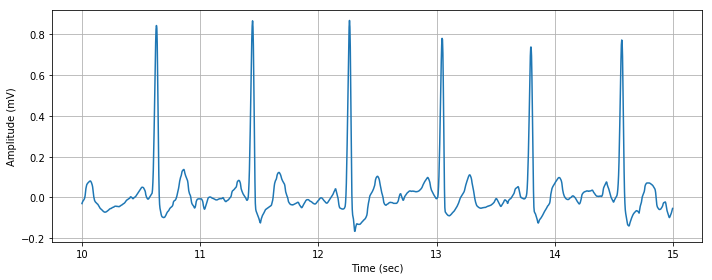

In [7]:
batch_with_data.show_ecg('A00001', start=10, end=15)

For detection of QRS intervals, P-waves and T-waves we need to train model first.

Download the [QT Database](https://www.physionet.org/physiobank/database/qtdb/) with labeled ECGs. Let ```SIGNALS_PATH``` be the folder where database is saved.

In [8]:
from cardio.pipelines import hmm_preprocessing_pipeline, hmm_train_pipeline
import warnings
warnings.filterwarnings('ignore')

SIGNALS_PATH = "path_to_QT_database" #set path to QT database
SIGNALS_MASK = os.path.join(SIGNALS_PATH, "*.hea")

index = ds.FilesIndex(path=SIGNALS_MASK, no_ext=True, sort=True)
dtst = ds.Dataset(index, batch_class=EcgBatch)

pipeline = hmm_preprocessing_pipeline()
ppl_inits = (dtst >> pipeline).run()

pipeline = hmm_train_pipeline(ppl_inits)
ppl_train = (dtst >> pipeline).run()

Save model

In [9]:
ppl_train.save_model("HMM", path="model_dump.dll")

Let's make prediction with hmm model

In [10]:
from cardio.pipelines import hmm_predict_pipeline

res = (eds >> hmm_predict_pipeline("model_dump.dll")).run()

Plot ECG signal with detected QRS intervals, P-waves and T-waves

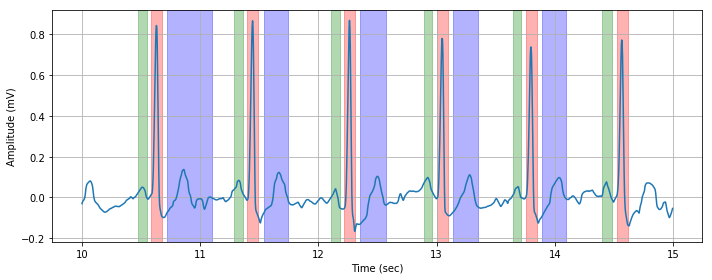

In [11]:
batch = res.get_variable("batch")[0]
batch.show_ecg('A00001', start=10, end=15, annotate=True)

For detection of atrial fibrillation we need to train another model.
Download the PhysioNet short single lead ECG database from [here](https://physionet.org/challenge/2017/). Let AF_SIGNALS_PATH be the folder where database is saved.

In [12]:
from cardio.pipelines import dirichlet_train_pipeline

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33, allow_growth=True)

AF_SIGNALS_PATH = "path_to_PhysioNet_database" #set path to PhysioNet database
AF_SIGNALS_MASK = os.path.join(AF_SIGNALS_PATH, "*.hea")
AF_SIGNALS_REF = os.path.join(AF_SIGNALS_PATH, "REFERENCE.csv")

index = ds.FilesIndex(path=AF_SIGNALS_MASK, no_ext=True, sort=True)
afds = ds.Dataset(index, batch_class=EcgBatch)

pipeline = dirichlet_train_pipeline(AF_SIGNALS_REF, gpu_options=gpu_options)
train_ppl = (afds >> pipeline).run()

Save model

In [13]:
model_path = "af_model_dump"
train_ppl.save_model("dirichlet", path=model_path)

In [14]:
from cardio.pipelines import dirichlet_predict_pipeline

pipeline = dirichlet_predict_pipeline(model_path, gpu_options=gpu_options)
res = (eds >> pipeline).run()
pred = res.get_variable("predictions_list")

Get predicted probalilities for artrial fibrillation

In [15]:
print([x["target_pred"]["A"] for x in pred])

[0.023025591, 0.038499158, 0.62477773, 0.65189326, 0.019785883, 0.020169117]
